In [1]:
# Library imports (see /Utilities/setup_env.py for full import list and figure setup)

from pathlib import Path
import sys

repo_root = Path.cwd().parents[1]  # .../Figure_analysis
repo_root = repo_root.parent       # repo root
sys.path.insert(0, str(repo_root))

from Figure_analysis.Utilities.setup_env import *

# set font size
mpl.rcParams.update({'font.size': 7})

def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

In [2]:
def calculate_r2_from_fit(merged_dG, x_col = 'dG', y_col = 'dG_imino', x_label = 'DMS', y_label = 'NMR'):
    linear_model = LinearModel()
    params = linear_model.guess(merged_dG[y_col], x=merged_dG[x_col])
    result = linear_model.fit(merged_dG[y_col], params, x=merged_dG[x_col])

    # calculate r2
    r2 = result.rsquared
    return r2

def plot_linear_correlation(
    merged_dG,
    x_col='dG',
    y_col='dG_imino',
    x_err_col='dG_err',
    y_err_col='dG_err_imino',
    x_label='DMS',
    y_label='NMR',
    construct='4U',
    temp=20,
):
    linear_model = LinearModel()
    params = linear_model.guess(merged_dG[y_col], x=merged_dG[x_col])
    result = linear_model.fit(merged_dG[y_col], params, x=merged_dG[x_col])

    print(result.fit_report())

    fig, ax = plt.subplots(figsize=(2, 2))
    ax.scatter(merged_dG[x_col], merged_dG[y_col], color='black', s=8)
    ax.plot(merged_dG[x_col], result.best_fit, color='black', linewidth=1)

    # ---- plot errors only if requested ----
    plot_xerr = x_err_col not in (None, 'none')
    plot_yerr = y_err_col not in (None, 'none')

    if plot_xerr or plot_yerr:
        for i in range(len(merged_dG)):
            x = merged_dG[x_col].iloc[i]
            y = merged_dG[y_col].iloc[i]

            x_err = merged_dG[x_err_col].iloc[i] if plot_xerr else None
            y_err = merged_dG[y_err_col].iloc[i] if plot_yerr else None

            ax.errorbar(
                x, y,
                xerr=x_err,
                yerr=y_err,
                fmt='none',
                color='black',
                capsize=1,
                elinewidth=0.5,
            )

    label = r'$\Delta G^\degree_{XXX, TTT^\circ\mathrm{C}}$ (kcal/mol)'
    label = label.replace('TTT', str(temp))
    ax.set_xlabel(label.replace('XXX', x_label))
    ax.set_ylabel(label.replace('XXX', y_label))

    if x_label == 'endpt':
        ax.set_xlabel('ln(Mut. Rate)')
    elif x_label == 'endpt2':
        ax.set_xlabel('Pseudo-free energy (kcal/mol)')
    if y_label == 'endpt':
        ax.set_ylabel('ln(Mut. Rate)')
    elif y_label == 'endpt2':
        ax.set_ylabel('Pseudo-free energy (kcal/mol)')

    # ax.set_ylim(1, 5)

    r2 = result.rsquared
    ax.annotate(
        f'$R^2$ = {r2:.2f}',
        xy=(0.95, 0.05),
        xycoords='axes fraction',
        fontsize=9,
        ha='right',
        va='bottom',
    )

    plt.tight_layout()
    plt.savefig(f'{construct}_{y_label}_v_{x_label}.pdf')
    print(f'Saving figure as {construct}_{y_label}_v_{x_label}.pdf')
    plt.show()

In [10]:
# NMR imino energies
nmr_energies_wt = pd.read_csv('NMR_imino/fourU_imino_ref_WT_Rinnenthal2011_processed.csv')
nmr_energies_wt['disp_name'] = '4U_wt'
nmr_energies_a8c = pd.read_csv('NMR_imino/fourU_imino_ref_A8C_Rinnenthal2011_processed.csv')
nmr_energies_a8c['disp_name'] = '4U_a8c'
nmr_energies = pd.concat([nmr_energies_wt, nmr_energies_a8c], ignore_index=True)

# NN-based energies (ensemble)
nn_energies_wt = pd.read_csv('NNensemble/fourU/WT_25C.csv')
nn_energies_wt['disp_name'] = '4U_wt'
nn_energies_a8c = pd.read_csv('NNensemble/fourU/A8C_25C.csv')
nn_energies_a8c['disp_name'] = '4U_a8c'
nn_energies = pd.concat([nn_energies_wt, nn_energies_a8c], ignore_index=True)

# PRIME-dG energies
prime_energies = pd.read_csv('PRIME-dG/fourU_dG.csv')
prime_energies['site'] = prime_energies['site_num'].astype(int)
prime_energies['disp_name'] = prime_energies['construct'].astype(str)

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 16
    # variables        = 2
    chi-square         = 1.25486644
    reduced chi-square = 0.08963332
    Akaike info crit   = -36.7289532
    Bayesian info crit = -35.1837758
    R-squared          = 0.80440746
[[Variables]]
    slope:      0.25790634 +/- 0.03398882 (13.18%) (init = 0.2579063)
    intercept:  1.36525826 +/- 0.17278557 (12.66%) (init = 1.365258)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9013


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


Saving figure as 4U_DMS_v_NMR.pdf


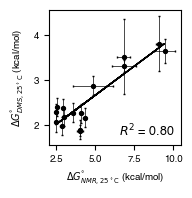

In [12]:
prime_v_nmr = pd.merge(prime_energies, nmr_energies, on=['site', 'disp_name'], suffixes=('_prime', '_nmr'))
calculate_r2_from_fit(prime_v_nmr, x_col='dG_prime', y_col='dG_calc_25')

plot_linear_correlation(
    prime_v_nmr,
    y_col='dG_prime',
    y_err_col='dG_err_prime',
    x_col='dG_nmr',
    x_err_col='dG_err_nmr',
    y_label='DMS',
    x_label='NMR',
    construct='4U',
    temp=25,
)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 24
    # variables        = 2
    chi-square         = 2.63643191
    reduced chi-square = 0.11983781
    Akaike info crit   = -49.0070570
    Bayesian info crit = -46.6509494
    R-squared          = 0.85941470
[[Variables]]
    slope:      0.37779009 +/- 0.03257675 (8.62%) (init = 0.3777901)
    intercept:  0.77377267 +/- 0.13390914 (17.31%) (init = 0.7737727)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.8494
Saving figure as 4U_DMS_v_NN.pdf


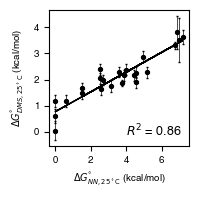

In [13]:
prime_v_nn = pd.merge(prime_energies, nn_energies, on=['site', 'disp_name'], suffixes=('_prime', '_nn'))

plot_linear_correlation(
    prime_v_nn,
    y_col='dG_prime',
    y_err_col='dG_err',
    x_col='dG_nn',
    x_err_col=None,
    x_label='NN',
    y_label='DMS',
    construct='4U',
    temp=25,
)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 16
    # variables        = 2
    chi-square         = 6.18903328
    reduced chi-square = 0.44207381
    Akaike info crit   = -11.1969571
    Bayesian info crit = -9.65177970
    R-squared          = 0.83541619
[[Variables]]
    slope:      0.63631279 +/- 0.07548293 (11.86%) (init = 0.6363128)
    intercept:  1.73761022 +/- 0.38372503 (22.08%) (init = 1.73761)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9013
Saving figure as 4U_NN_v_NMR.pdf


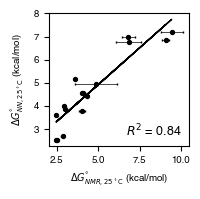

In [14]:
nmr_v_nn = pd.merge(nmr_energies, nn_energies, on=['site', 'disp_name'], suffixes=('_nmr', '_nn'))

plot_linear_correlation(
    nmr_v_nn,
    x_col='dG_nmr',
    x_err_col='dG_err',
    y_col='dG_nn',
    y_err_col=None,
    x_label='NMR',
    y_label='NN',
    construct='4U',
    temp=25,
)